# Resting Heart Rate Regression Model Using Fitbit data

Resting heart rate (RHR) is a person's heart rate when they are physically inactive and even mentally unstimulated (or resting). Often one's RHR thought to be a predictor of health, with typical values in the range of 50-90 beats per minute. 

Since RHR can be lowered by exercise and overall improving your health, I thought I would try to predict my RHR based on my activity level and time asleep supplied by my Fitbit data. Fitbit also tracks your heart rate, measuring it and recording it every 10 minutes. 

The aim of this project is to predict my RHR based on three features-- daily minutes walked, daily minutes of working out, and daily sleep duration in minutes. The target is my RHR, calculated by averaging my heart rate between 1 AM and 5:30 AM every night while I am asleep. I will first train a linear regression model using this data.

In [1]:
import os
import pandas as pd 
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt

Below, we import the heart rate, sleep, and exericse data. We only extract the data we will turn into features.

In [4]:
heart_rate_data = pd.DataFrame()
for heart_rate_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/heart_rate-202*')):       
   df = pd.read_json(heart_rate_file)
   bpm = list()
   index_list = list(range(len(df.index)))
   for index in index_list:
       bpm_point = df.loc[index, 'value']['bpm']
       bpm_point = np.float64(bpm_point)
       bpm.append(bpm_point)
   bpm = pd.Series(bpm)
   da = pd.concat([df['dateTime'], bpm], axis = 1)
   heart_rate_data = heart_rate_data.append(da) 

sleep_data = pd.DataFrame() 
for sleep_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Sleep/sleep-20*')):
   df = pd.read_json(sleep_file)
   da = pd.concat([pd.to_datetime(df['dateOfSleep']), df['minutesAsleep']], axis = 1)
   sleep_data = sleep_data.append(da)

exercise_data = pd.DataFrame() 
for exercise_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/exercise*')):
   df = pd.read_json(exercise_file, dtype = True)
   da = pd.DataFrame([df['startTime'], df['activityName'], df['duration']*1.6667e-5]) #convert duration from milliseconds to min
   da = da.transpose()
   da['startTime'] = pd.to_datetime(da['startTime'])
   exercise_data = exercise_data.append(da) 

print(heart_rate_data.head())
print(sleep_data.head())
print(exercise_data.head())

             dateTime     0
0 2020-06-13 13:58:03  68.0
1 2020-06-13 13:58:18  69.0
2 2020-06-13 13:58:33  71.0
3 2020-06-13 13:58:38  72.0
4 2020-06-13 13:58:43  72.0
  dateOfSleep  minutesAsleep
0  2019-03-22            433
1  2019-03-21            435
2  2019-03-20            512
3  2019-03-19             64
4  2019-03-19            336
            startTime activityName duration
0 2019-02-21 17:13:22         Walk  24.8005
1 2019-02-22 17:10:26         Walk   15.367
2 2019-02-23 01:39:02         Walk  11.9336
3 2019-02-24 23:36:10         Walk  30.7173
4 2019-02-25 17:30:31         Walk  19.6337


Next, we calculate the RHR between 1 AM and 5:30 AM every day. We now have a resting heart rate for each day that data was collected. It shows us we have 439 days of heart rate data (the number of rows in the DataFrame).

In [5]:
start = datetime.time(1,0,0)
end = datetime.time(5,30,0)

#heart_rate_data = heart_rate_data.drop(['level_0', 'index'], axis = 1)
heart_rate_data.columns = ['dateTime', 'bpm']
heart_rate_data.loc[:,'dateTime'] = pd.DatetimeIndex(heart_rate_data.loc[:,'dateTime'])
heart_rate_data.set_index(keys = 'dateTime', inplace = True)
rhrData = heart_rate_data.between_time(start, end) #Return DataFrame with data between 1 AM and 5:30 AM, average of which will be RHR
rhrData.reset_index(inplace = True)
rhrData.head()
rhrData.columns = ['dateTime', 'bpm']
rhrData.loc[:,'date'] = rhrData.loc[:,'dateTime'].dt.date
rhr_df = pd.pivot_table(rhrData, values = 'bpm', index = 'date', aggfunc = np.mean)
rhr_df.info

C:\Users\Lauren-Nizkorodov\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Lauren-Nizkorodov\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<bound method DataFrame.info of                   bpm
date                 
2020-06-14  65.616183
2020-06-15  62.998874
2020-06-16  59.206481
2020-06-17  61.912371
2020-06-19  60.634325
...               ...
2021-01-16  59.763559
2021-01-17  57.647002
2021-01-18  59.039645
2021-01-19  58.032787
2021-01-20  62.293760

[217 rows x 1 columns]>

For the exercise data, we sum the daily number of minutes for each activity using a pivot table. 
We discard running and biking activities since I don't seem to do these activities (they are null). I combined sport and aerobic workouts since my fitbit registers my workout using either of these activities.

The sleep data doesn't require much manipulation. All that's needed is to set the date as the index of the DataFrame for a successful join of all DataFrames.

In [6]:
exercise_data['date'] = exercise_data['startTime'].dt.date
exercise_data_df = pd.pivot_table(exercise_data, values = 'duration', columns = 'activityName', index = 'date', aggfunc = np.sum)
exercise_data_df.drop(['Run', 'Outdoor Bike'], axis = 1, inplace = True)   #Run and outdoor bike activities are completely null
exercise_data_df = exercise_data_df.fillna(0)
exercise_data_df['workout'] = exercise_data_df['Aerobic Workout'] + exercise_data_df['Sport']  #Working out can register on Fitbit as either of these
exercise_data_df.drop(['Aerobic Workout', 'Sport'], axis = 1, inplace = True) #Don't need this now, just clean up step

sleep_data.set_index('dateOfSleep', inplace = True)

The exercise, sleep, and RHR data are joined on the date in a single table.

The index list is shuffled, and 80% of the data goes into the test set, 10% in the cross validation set, and the remaining 10% in the test set.

In [7]:
all_data = exercise_data_df.join([sleep_data, rhr_df])
all_data.dropna(axis = 0, inplace = True)
all_data.reset_index(inplace = True)
all_data.drop('index', axis = 1, inplace = True)
index_list = list(range(0, round(len(all_data))))
np.random.shuffle(index_list)
trainIndex = index_list[0:(round(0.8*len(index_list)))]
crossValIndex = index_list[len(trainIndex): round((((len(index_list)-len(trainIndex))/2) + len(trainIndex)))]
testIndex = index_list[(len(trainIndex) + len(crossValIndex)) :]

The data is split up according to the assigned indices. The data is split into X, comprised of insta.nces of features (daily workout min, daily walking min, and sleep duration in minutes. The corresponding y values are the calculated resting heart rate based on the heart rate data. The intercept "feature" (x0) is added, which is just a feature of ones.

In [8]:
X = all_data.iloc[:,:-1]
Xtrain = X.loc[trainIndex, :]
Xtrain = Xtrain.to_numpy()
Xtrain = np.c_[np.ones((Xtrain.shape[0],1)), Xtrain]
y = all_data.loc[:,'bpm'].to_numpy()
ytrain = y[trainIndex]
XcrossVal = X.loc[crossValIndex, :].to_numpy()
XcrossVal = np.c_[np.ones((XcrossVal.shape[0],1)), XcrossVal]
ycrossVal = y[crossValIndex]
Xtest = X.loc[testIndex, :].to_numpy()
Xtest = np.c_[np.ones((Xtest.shape[0],1)), Xtest]
ytest = y[testIndex]

Theta is solved for first using the normal equation, and precitions of RHR (y_predict) are made for the cross validation set based on the calculated theta parameters.

Next, the Sci-kit Learn library is used to determine theta based on the same test set. Predictions of RHR are made again on the cross validation set to compare to the normal equation method. The graph shows the difference in the methods predictions, which are nearly zero (on the order of 10E-13) for all cross validation instances.

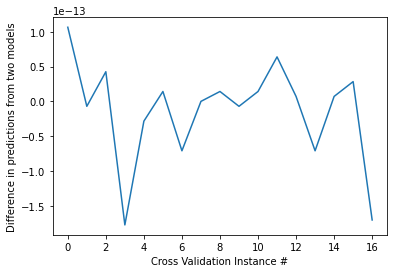

the normal equation found theta to be  [ 6.43724387e+01  3.13391318e-03 -7.73790052e-02 -8.27474425e-03] with a cost of  5.254505760692925
sci-kit learn found theta to be  64.37243871779236 [ 0.          0.00313391 -0.07737901 -0.00827474]


In [9]:
#My model
theta_best = np.linalg.inv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain) #use normal equation to find theta since have relatively small training set
y_predict = XcrossVal.dot(theta_best)
sq_error = np.square((y_predict - ycrossVal))
J = (1/2/len(y_predict)) * sum(sq_error)

#sklearn model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
lin_reg.intercept_, lin_reg.coef_
y_predict_sklearn = lin_reg.predict(XcrossVal)
fig, ax = plt.subplots()
ax.plot(y_predict - y_predict_sklearn)
ax.set(xlabel='Cross Validation Instance #', ylabel='Difference in predictions from two models')
plt.show()

print('the normal equation found theta to be ' , theta_best, 'with a cost of ', J)
print('sci-kit learn found theta to be ' , lin_reg.intercept_, lin_reg.coef_)

The predictions of resting heart rate are not good, though. The predictions are in a smaller range from 60-68, whereas my actual RHR range was 50-80.

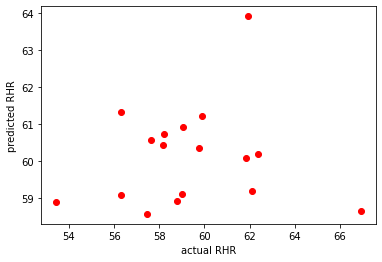

In [10]:
fig, ax = plt.subplots()
ax.plot(ycrossVal, y_predict, 'ro')
ax.set(xlabel='actual RHR', ylabel='predicted RHR')
plt.show()

To figure out if variance or bias is the problem with our model (or a bit of both), we make learning curves.

Bias is a result of the model underfitting the data, and to make a better model we can add polynomial features or add more features.
Variance is a result of the model overfitting the data. To recify this, a larger training set could help.

[]
[ 6.66374508e+01 -4.85375806e-03 -4.24077683e-02 -1.10208479e-02]
(63, 3)


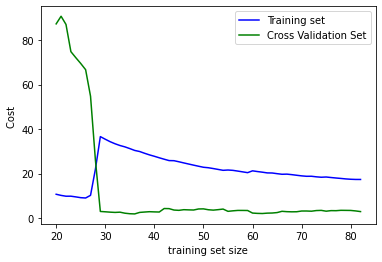

In [37]:
def computeTheta(Xtrain, ytrain):
	theta = np.linalg.inv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain)
	return theta

def computeCost(m, yPredict, y):
	sq_error = np.square((yPredict - y))
	J = (1/2/m) * sum(sq_error)
	return J

learning_curve_data = np.array([])
print(learning_curve_data)
i = list(range(20, round(len(index_list)/2)))

for a in i:
	np.random.shuffle(index_list)
	all_data.loc[index_list, :]
	trainData = all_data.loc[0:a, :]
	crossValData = all_data.loc[(a+1):(a+1+len(crossValIndex)), :]
	Xtrain = trainData.iloc[:, :-1]
	Xtrain = Xtrain.to_numpy()
	Xtrain = np.c_[np.ones((Xtrain.shape[0],1)), Xtrain]
	ytrain = trainData.loc[:, 'bpm']
	XCV = crossValData.iloc[:, :-1]
	XCV = XCV.to_numpy()
	XCV = np.c_[np.ones((XCV.shape[0],1)), XCV]
	yCV = crossValData.loc[:, 'bpm']
	theta = computeTheta(Xtrain, ytrain)
	yPredictCV = XCV.dot(theta)
	yPredictTrain = Xtrain.dot(theta)
	Jtrain = computeCost(a, yPredictTrain, ytrain)
	JCV = computeCost(a, yPredictCV, yCV)
	iteration = np.array([a, Jtrain, JCV])
	learning_curve_data = np.concatenate((learning_curve_data, iteration), axis = 0)

print(theta)
learning_curve_data = np.reshape(learning_curve_data, (-1, 3))  
print(learning_curve_data.shape)
fig, ax = plt.subplots()
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 1], 'b-', label = 'Training set')
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 2], 'g-', label = 'Cross Validation Set')
ax.set(xlabel='training set size', ylabel='Cost ')
ax.legend()
plt.show()


The cost for the training set increases with the training set size since with every instance added it becomes harder to perfectly fit the data. The cross validation set has a high cost to begin with and decreases as there are more training examples and theta fits generalized data better (and not just fits the training set). 

Adding more training instances is not likely to help decrease the cost further. Instead, we will try polynomial features.

The next model I am trying is: (walk minutes)^2 + (workout minutes)^2 + (time asleep)^2 = resting heart rate

I first square all of the features, then compute theta, and predict the resting heart rate in the same way as before.

In [67]:
square_all_data = all_data.iloc[:, :-1] ** 2
all_ys = all_data.iloc[:, -1]
train_set_size = round(len(all_data)*0.8)  #80% of all instances go into the training set
CrossVal_set_size = round(len(all_data)*0.095)  #10% of all instances go into the cross val set
test_set_size = round(len(all_data)*0.095)  #10% of all instances go into the test set
trainSetIndex = list(range(0, train_set_size))
CrossValIndex = list(range(train_set_size, train_set_size + CrossVal_set_size))
testSetIndex = list(range(CrossVal_set_size + train_set_size, CrossVal_set_size + test_set_size + train_set_size))

XtrainSquared = square_all_data.iloc[trainSetIndex, :]
XtrainSquared = XtrainSquared.to_numpy()
XtrainSquared = np.c_[np.ones((XtrainSquared.shape[0],1)), XtrainSquared]
XCVSquared = square_all_data.iloc[CrossValIndex, :]
XCVSquared = XCVSquared.to_numpy()
XCVSquared = np.c_[np.ones((XCVSquared.shape[0],1)), XCVSquared]

ytrainSquared = all_ys.iloc[trainSetIndex]
ytrainSquared = ytrainSquared.to_numpy()
yCVSquared = all_ys.iloc[CrossValIndex]
yCVSquared = yCVSquared.to_numpy()
thetaSquared = computeTheta(XtrainSquared, ytrainSquared)
yPredictCVSquared = XCVSquared.dot(thetaSquared)
yPredictTSquared = XtrainSquared.dot(thetaSquared)

print('The cross validation cost for the model with squared features is', computeCost(CrossVal_set_size, yPredictCVSquared, yCVSquared))
print('The cross validation cost for the model with squared features is', computeCost(train_set_size, yPredictTSquared, ytrainSquared))

The cross validation cost for the model with squared features is 18.589269727253825
The cross validation cost for the model with squared features is 13.594339249096109


This model actually performs worse than the last one.
Is the problem bias or variance? Let's do another learning curve.